<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bert Sentiment Analysis

In [1]:
import tensorflow
from transformers import TFBertModel

### Definiendo modelo

In [2]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Para entrenar el modelo con el score es necesario ajustar output shape a 5

In [3]:
max_length = 140
output_shape = 5

In [4]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

dense_layer = tensorflow.keras.layers.Dense(units=128, activation='relu')(pooled_output)
x = tensorflow.keras.layers.Dropout(0.2)(dense_layer)

output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

### Importamos resto de librerías

In [5]:
import os

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer  # Métodos para transformar el dataset
from transformers import InputExample, InputFeatures
from tf_keras.optimizers import Adam

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

In [7]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train acc')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid acc')
    sns.lineplot(x=epoch_count,  y=history.history['f1_score'], label='train f1-score')
    sns.lineplot(x=epoch_count,  y=history.history['val_f1_score'], label='valid f1-score')
    plt.show()

### Datos
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [8]:
# Descargar la carpeta de dataset
if os.access("apps.csv", os.F_OK) is False:
    url = "https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download"
    output = "apps.csv"
    gdown.download(url, output, quiet=False)
else:
    print("apps.csv ya se encuentra descargado")
if os.access("reviews.csv", os.F_OK) is False:
    url = "https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download"
    output = "reviews.csv"
    gdown.download(url, output, quiet=False)
else:
    print("reviews.csv ya se encuentra descargado")

apps.csv ya se encuentra descargado
reviews.csv ya se encuentra descargado


In [9]:
# Armar el dataset
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [10]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


<Axes: xlabel='score', ylabel='count'>

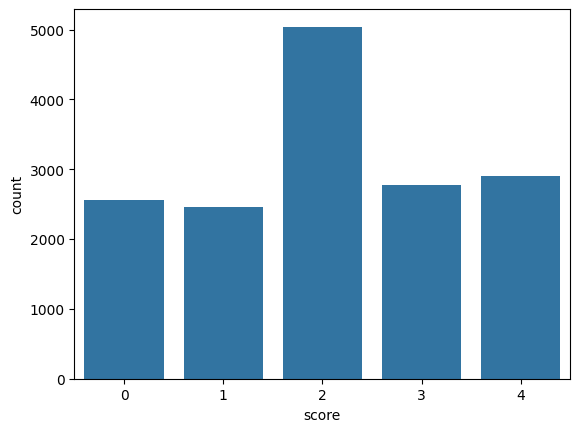

In [11]:
# ¿Cómo están balanceados los datos?
df['score'] = df['score'] - 1 # Corregir el dataset para que no genere una categoría de más.
sns.countplot(x=df.score)

## Limpieza de datos

Se decide no modificar el set de datos y trabajar sobre el score, el cual está desbalanceado

In [12]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


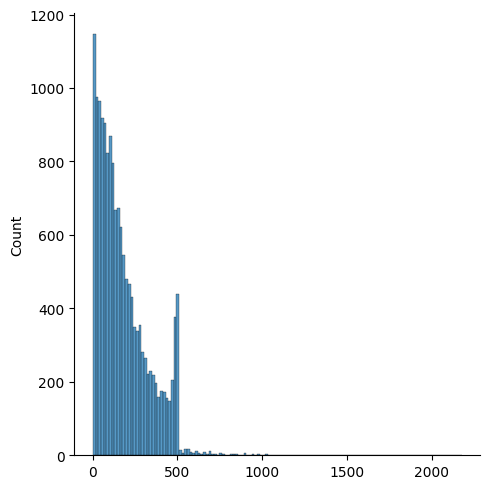

In [13]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

In [14]:
y = df['score'].values
print("y shape:", y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
output shape: 5


## 1 - Data generator


In [15]:
# Muy importante que para tensorflow los modelos Bert deben empezar con "TF"
# de lo contrario estaremos utilizando un modelo para pytorch

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

c:\Users\Lorda\Source\Repos\CEIA\len-nat\.env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente
max_length = 140 # BERT soporta máximo 512
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [17]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [18]:

def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i], 
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]
  
    return train_InputExamples, validation_InputExamples

 
def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

In [19]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [20]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [21]:
X_test = [tf_batch['input_ids'],  
          tf_batch['attention_mask']]

In [22]:
y_test = y[idx_test]

## 2 - BERT multiclass classification

In [23]:
history1 = model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5


315/315 [==============================] - 619s 2s/step - loss: 1.5645 - accuracy: 0.3175 - f1_score: 0.1599 - val_loss: 1.5106 - val_accuracy: 0.3718 - val_f1_score: 0.1982
Epoch 2/5
315/315 [==============================] - 640s 2s/step - loss: 1.4699 - accuracy: 0.3658 - f1_score: 0.1991 - val_loss: 1.4198 - val_accuracy: 0.3964 - val_f1_score: 0.2206
Epoch 3/5
315/315 [==============================] - 618s 2s/step - loss: 1.4069 - accuracy: 0.3915 - f1_score: 0.2290 - val_loss: 1.3683 - val_accuracy: 0.4286 - val_f1_score: 0.3020
Epoch 4/5
315/315 [==============================] - 612s 2s/step - loss: 1.3771 - accuracy: 0.4027 - f1_score: 0.2545 - val_loss: 1.3462 - val_accuracy: 0.4278 - val_f1_score: 0.2991
Epoch 5/5
315/315 [==============================] - 620s 2s/step - loss: 1.3602 - accuracy: 0.4130 - f1_score: 0.2839 - val_loss: 1.3686 - val_accuracy: 0.4052 - val_f1_score: 0.2771


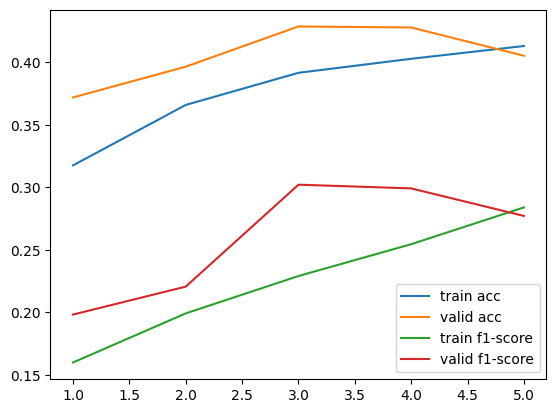

In [24]:
plot_train_metrics(history1)

Guardamos el progreso del entrenamiento

In [25]:
model.save_weights('original_weights.h5')

Probamos el modelo cargandolo desde el fichero

In [26]:
model2 = model
model2.load_weights('original_weights.h5')

In [27]:
y_hat_prob = model2.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 142s 1s/step


array([[0.26718524, 0.21672305, 0.31581092, 0.13336079, 0.06692001],
       [0.1763232 , 0.17257743, 0.27600893, 0.19582607, 0.17926432],
       [0.05595183, 0.08565459, 0.2715586 , 0.2919155 , 0.29491946]],
      dtype=float32)

In [28]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [29]:
# Calcular la exactitud (accuracy)
scores = model2.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 143s 1s/step - loss: 1.3755 - accuracy: 0.3873 - f1_score: 0.2682


0.38730159401893616

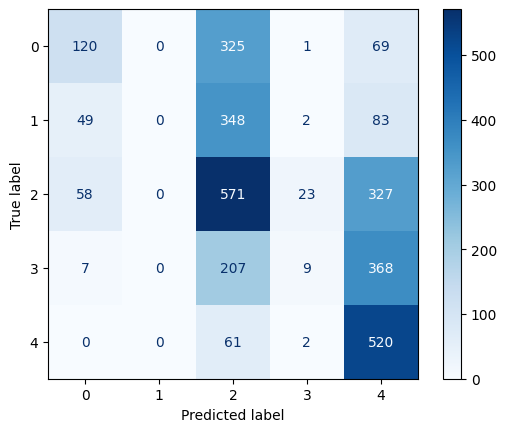

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(5)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

El resultado mostrado en la matriz de confusión indica un mal desempeño del modelo. Es necesario emplear fine tuning para mejorar los resultados.

## 3 - BERT Fine tuning

In [32]:
# Colocar todas las layers como entrenables
for layer in model2.layers:
  layer.trainable = True

# Como es fine tunning se recomiendo utiliza al menos un learning rate 100 veces
# menor
optimizer = Adam(learning_rate=0.00001)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.F1Score(average='macro')])

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

In [33]:
history2 = model2.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
315/315 [==============================] - 1616s 5s/step - loss: 1.2015 - accuracy: 0.4736 - val_loss: 1.0910 - val_accuracy: 0.5353
Epoch 2/5
315/315 [==============================] - 1594s 5s/step - loss: 1.0679 - accuracy: 0.5303 - val_loss: 1.0331 - val_accuracy: 0.5639
Epoch 3/5
315/315 [==============================] - 1595s 5s/step - loss: 0.9549 - accuracy: 0.5851 - val_loss: 1.0046 - val_accuracy: 0.5837
Epoch 4/5
315/315 [==============================] - 1581s 5s/step - loss: 0.8315 - accuracy: 0.6499 - val_loss: 0.9908 - val_accuracy: 0.6294
Epoch 5/5
315/315 [==============================] - 1580s 5s/step - loss: 0.6982 - accuracy: 0.7164 - val_loss: 1.0424 - val_accuracy: 0.6365


KeyError: 'f1_score'

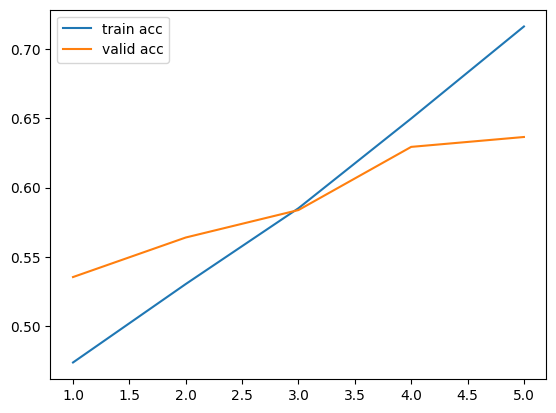

In [34]:
plot_train_metrics(history2)

In [35]:
y_hat_prob2 = model2.predict(X_test)
y_hat_prob2[:3]

99/99 [==============================] - 145s 1s/step


array([[0.0373825 , 0.14746977, 0.6537515 , 0.15791433, 0.00348188],
       [0.25995833, 0.55072355, 0.16713089, 0.02093914, 0.00124812],
       [0.00371604, 0.01870049, 0.59084505, 0.38402903, 0.00270929]],
      dtype=float32)

In [36]:
y_hat2 = np.argmax(y_hat_prob2, axis=1)

In [37]:
# Calcular la exactitud (accuracy)
scores = model2.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 143s 1s/step - loss: 1.0443 - accuracy: 0.6308


0.6307936310768127

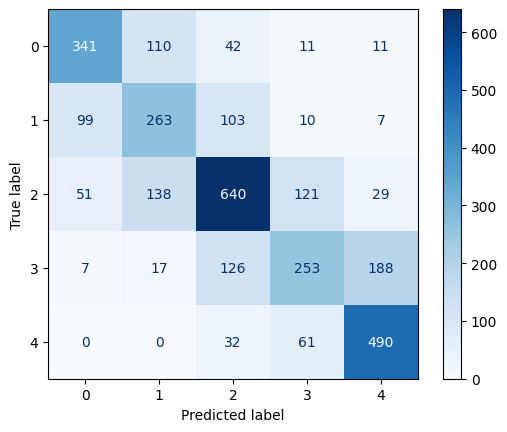

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat2)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(5)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

## Salvar el modelo

In [39]:
model2.save_weights('bert_weights.h5')

In [63]:
# # Descargar los pesos a nuestra PC
# # Solo es necesario si se desea repetir el uso de este modelo en el futuro
# from google.colab import files
# files.download('bert_weights.h5')

## Levantar el modelo

In [40]:
bert_model3 = TFBertModel.from_pretrained("bert-base-uncased")

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')

# attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
# Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH, 
# and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
attention_mask = tensorflow.keras.layers.Input((max_length,), dtype=tensorflow.int32, name='attention_mask')

# Get the pooled_output (embedding que representa toda la entrada)
output = bert_model3([input_ids, attention_mask])[1] 

# We can also add dropout as regularization technique:
output = tensorflow.keras.layers.Dropout(rate=0.2)(output)

# Se puede agregar más capas Densas en el medio si se desea

# Provide number of classes to the final layer:
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(output)

# Final model:
model3 = tensorflow.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

ValueError: Exception encountered when calling layer 'tf_bert_model_1' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_bert_model_1' (type TFBertModel):
  • input_ids=['<KerasTensor shape=(None, 140), dtype=int32, sparse=False, name=input_ids>', '<KerasTensor shape=(None, 140), dtype=int32, sparse=False, name=attention_mask>']
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [ ]:
model3.load_weights('bert_weights.h5')

## Ensayo

In [ ]:
text = "I love this app!"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

In [ ]:
X_ensayo = [tf_batch['input_ids'],  
          tf_batch['attention_mask']]

In [ ]:
y_prob_ensayo = model3.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

## Conclusiones

Este desafio presenta con bastante detalle el proceso necesario para el uso de modelos preentrenados (Como Bert) para el análisis y procesamiento de texto. En los casos en los que el resultado no sea suficiente, existe la posibilidad de reentrenar estos modelos y ajustarlos para que tenga un mejor desempeño del problema, con el coste computacional y de tiempo que ésto conlleva.

Esta reflexión queda reflejada en la comparación de las dos matrices de confusión antes y después del fine-tuning, el cual también despierta ideas como la posibilidad de overfittear el modelo si se entrena demasiado.